In [420]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import random

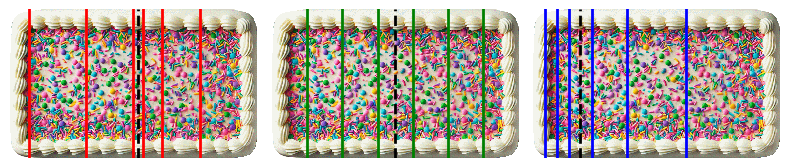

In [428]:
# Initialise piecewise uniform values
values = [[1, 4, 6.5, 7, 8, 10, 13],
          [2, 4, 6, 8, 10, 12, 14],
          [1, 2, 3, 5, 8, 13, 21]]

# Declare array of colours for each value set
colors = ["red", "green", "blue"]

# Read in the cake image
cake = skimage.io.imread("cake.png") / 255.0

# Instantiate a figure
fig, axs = plt.subplots(1, len(values), figsize=(8, 4))

# Loop over the values array 
for idx, (value_set, ax) in enumerate(zip(values, axs)):
    ax.imshow(cake, cmap="gray", interpolation="nearest")
    ax.axis("off")

    # Declare the end of the image and the values
    pixel_width = cake.shape[1]
    slice_width = value_set[-1]

    # Plot a line for each equal value section
    for value in value_set[:-1]:
        position = pixel_width * (value / slice_width)
        ax.axvline(x=position, color= colors[idx], linestyle='-', linewidth=2)
    ax.axvline(x=pixel_width * (cut_position(value_set, 0.5) ), color="black", linestyle='--', linewidth=2)

# Display the figure with a tight layout
plt.tight_layout()
plt.show()



In [ ]:
def total_value(values):
    # return the number of pieces as they are all of equal value
    return len(values)

def cut_position(values, ratio):
    # return the whole cake in the special case where the user wants the whole cake
    if ratio == 1:
        return 1
    # calculate the desired number of pieces 
    slices_target = total_value(values) * ratio 
    # split the whole and fractional pieces for processing
    whole_pieces = int(slices_target)
    fractional_part = slices_target - whole_pieces
    # get the position of the last whole piece or zero where there are none
    position = values[whole_pieces - 1] if whole_pieces > 0 else 0
    # get the size of the next piece and add a fraction of that to the position
    next_jump = values[whole_pieces] - position
    position += fractional_part * next_jump
    # normalise and return the position
    return position / values[-1]

def evaluate(values, ratio):
    # get the precise position of the end of the cut
    cut_position = values[-1] * ratio
    # get the pieces that come before the cut
    left_pieces = [x for x in values if x < cut_position]
    # get the whole number position as zero or the last piece that comes before the cut
    reference_point = left_pieces[-1] if left_pieces else 0
    # get the width of the first non-left slice
    next_slice_width = values[len(left_pieces)] - reference_point
    # get the fractional width of the piece
    partition_width = cut_position - reference_point
    # add the ratio of the fractinal piece to the number of whole piece
    total_width = len(left_pieces) + partition_width / next_slice_width
    # return the normalised evaluation
    return total_width / len(values)


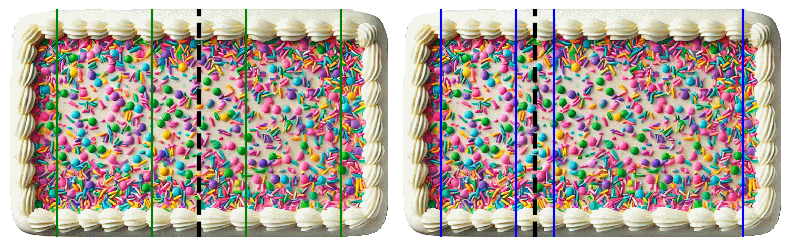

0.5 0.5
0.64 0.36


In [389]:
# Two person cut and choose

x = [x/10 for x in sorted(random.sample(range(1, 11), 5))]
y = [x/10 for x in sorted(random.sample(range(1, 11), 5))]

x_cut_pos = cut_position(x, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, values, color in zip(axes, [x, y], ["green", "blue"]):
    ax.imshow(cake, cmap="gray", interpolation="nearest")
    ax.axis("off")
    ax.axvline(x=pixel_width * cut_position(values, 0.5), color="black", linestyle='--', linewidth=3)
    for value in values[:-1]:
        ax.axvline(x=pixel_width * (value / values[-1]), color=color, linestyle='-', linewidth=1.5)

plt.tight_layout()
plt.show()

print(round(evaluate(x, cut_position(x, 0.5)), 2), round(1 - evaluate(x, cut_position(x, 0.5)), 2))
print(round(evaluate(y, cut_position(x, 0.5)), 2), round(1 - evaluate(y, cut_position(x, 0.5)), 2))


In [569]:
# three way selfridge-conway algorithm

# randomly generate three piecewise uniform value assignments
a, b, c = sorted(random.sample(range(1, 11), 5,)), sorted(random.sample(range(1, 11), 5,)), sorted(random.sample(range(1, 11), 5,))

# generate three slices of equal value according to agent a
initial_cuts = 0, cut_position(a, 1/3), cut_position(a, 2/3), 1
initial_slices = [(initial_cuts[i], initial_cuts[i+1]) for i in range(len(initial_cuts)-1)]

# generate evaluations from the perspective of agent b
initial_evaluations = evaluate(b, initial_cuts[1]), evaluate(b, initial_cuts[2]) - evaluate(b, initial_cuts[1]), 1 - evaluate(b, initial_cuts[1]) - (evaluate(b, initial_cuts[2]) - evaluate(b, initial_cuts[1]))


highest_piece = np.argsort(initial_evaluations)[-1]
second_highest_piece = np.argsort(initial_evaluations)[-2]
second_highest_value = initial_evaluations[second_highest_piece]

for i in range(len(initial_slices)):
    print(f"{i}: {initial_slices[i]} = {initial_evaluations[i]}")

trim_start = cut_position(b, second_highest_value + evaluate(b, initial_slices[highest_piece][0]))


trim = trim_start, initial_slices[np.argsort(initial_evaluations)[-1]][1]
initial_slices[highest_piece] = initial_slices[highest_piece][0], trim_start

for slice in initial_slices:
    print(evaluate(b,slice[1]) - evaluate(b,slice[0]))


0: (0, 0.18518518518518517) = 0.23209876543209879
1: (0.18518518518518517, 0.40740740740740733) = 0.11851851851851847
2: (0.40740740740740733, 1) = 0.6493827160493828
0.23209876543209879
0.11851851851851847
0.2320987654320989
